In [166]:
from langchain.schema import Document
from langchain.text_splitter import CharacterTextSplitter

# Load text data
text = """ Sarah is an employee at prismaticAI, a leading technology company based in Westside Valley. She has been working there for the past three years as a software engineer.
Michael is also an employee at prismaticAI, where he works as a data scientist. He joined the company two years ago after completing his graduate studies.
prismaticAI is a well-known technology company that specializes in developing cutting-edge software solutions and artificial intelligence applications. The company has a diverse workforce of talented individuals from various backgrounds.
Both Sarah and Michael are highly skilled professionals who contribute significantly to prismaticAI's success. They work closely with their respective teams to develop innovative products and services that meet the evolving needs of the company's clients."""

documents = Document(page_content=text)
text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=20)
texts = text_splitter.split_documents([documents])
texts

[Document(metadata={}, page_content="Sarah is an employee at prismaticAI, a leading technology company based in Westside Valley. She has been working there for the past three years as a software engineer.\nMichael is also an employee at prismaticAI, where he works as a data scientist. He joined the company two years ago after completing his graduate studies.\nprismaticAI is a well-known technology company that specializes in developing cutting-edge software solutions and artificial intelligence applications. The company has a diverse workforce of talented individuals from various backgrounds.\nBoth Sarah and Michael are highly skilled professionals who contribute significantly to prismaticAI's success. They work closely with their respective teams to develop innovative products and services that meet the evolving needs of the company's clients.")]

In [167]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [168]:
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer

llm=ChatOpenAI(model="gpt-4o-mini",temperature=0,openai_api_key=os.getenv("OPENAI_API_KEY"))

# Extract Knowledge Graph
llm_transformer = LLMGraphTransformer(llm=llm)
graph_documents = llm_transformer.convert_to_graph_documents(texts)

graph_documents

[GraphDocument(nodes=[Node(id='Sarah', type='Person', properties={}), Node(id='Michael', type='Person', properties={}), Node(id='Prismaticai', type='Company', properties={}), Node(id='Westside Valley', type='Location', properties={})], relationships=[Relationship(source=Node(id='Sarah', type='Person', properties={}), target=Node(id='Prismaticai', type='Company', properties={}), type='EMPLOYEE', properties={}), Relationship(source=Node(id='Michael', type='Person', properties={}), target=Node(id='Prismaticai', type='Company', properties={}), type='EMPLOYEE', properties={}), Relationship(source=Node(id='Prismaticai', type='Company', properties={}), target=Node(id='Westside Valley', type='Location', properties={}), type='BASED_IN', properties={}), Relationship(source=Node(id='Sarah', type='Person', properties={}), target=Node(id='Prismaticai', type='Company', properties={}), type='SOFTWARE_ENGINEER', properties={}), Relationship(source=Node(id='Michael', type='Person', properties={}), targ

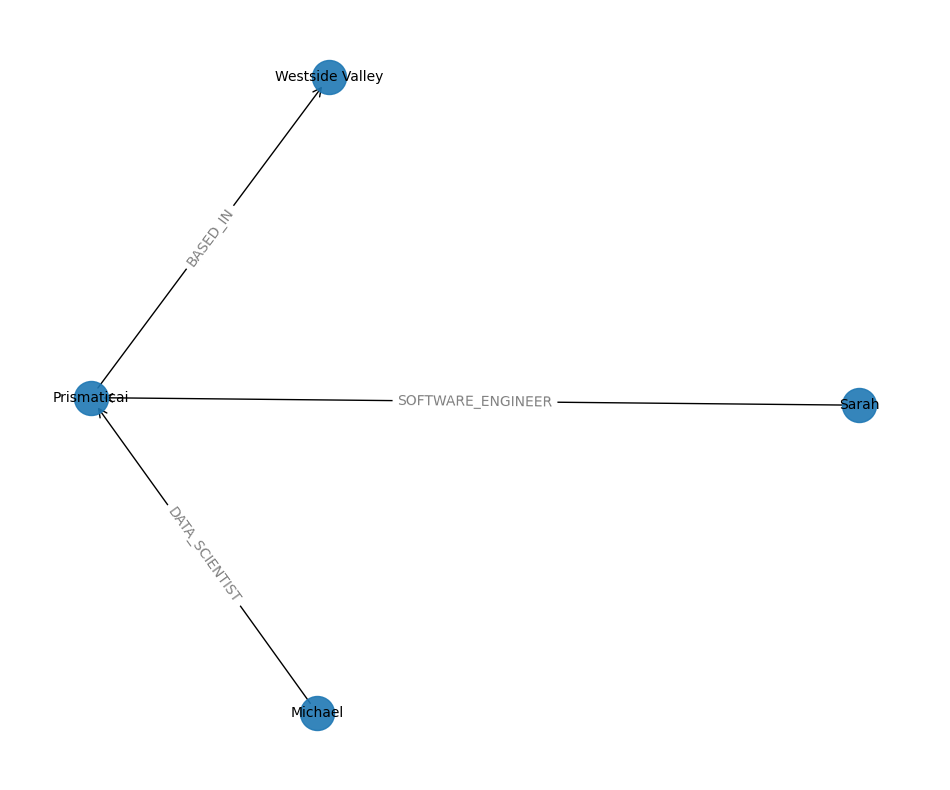

In [169]:
import networkx as nx
import matplotlib.pyplot as plt

doc = graph_documents[0]

# 2. Build a directed graph
G = nx.DiGraph()
for node in doc.nodes:
    G.add_node(node.id, label=node.type)
for rel in doc.relationships:
    # relationship.source and .target are Node objects
    G.add_edge(rel.source.id, rel.target.id, label=rel.type)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)  # for reproducible layout
nx.draw_networkx_nodes(G, pos, node_size=600, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="gray")

plt.axis("off")
plt.show()

In [ ]:
from langchain_neo4j import Neo4jGraph,GraphCypherQAChain

# Store Knowledge Graph in Neo4j
graph_store = Neo4jGraph(url="url.databases.neo4j.io", username="neo4j", password="")

In [171]:
graph_store.add_graph_documents(graph_documents)

In [178]:
print(graph_store.schema)

Node properties:
Person {id: STRING}
Company {id: STRING}
Location {id: STRING}
Relationship properties:

The relationships:
(:Person)-[:EMPLOYEE]->(:Company)
(:Company)-[:BASED_IN]->(:Location)


In [179]:
chain = GraphCypherQAChain.from_llm(llm=llm, graph=graph_store, verbose=True, allow_dangerous_requests=True)

In [180]:
# Query 1
result=chain.invoke({"query": "Where does Sarah works?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {id: 'Sarah'})-[:EMPLOYEE]->(c:Company) RETURN c.id
Full Context:
[{'c.id': 'Prismaticai'}]

> Finished chain.
